In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
def prepare(features, scale_factor=4, augment=True,
                     return_batch_as_tuple=True, seed=None):

    
    image = features
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    original_size_mult = scaled_size * scale_factor
    
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3: # batched data:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        image = tf.image.random_flip_left_right(image)

        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2, 
                                                dtype=tf.float32, seed=seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32), 
                                            random_scale_factor), 
                                tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32), 
                                           random_scale_factor), 
                               tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    image_downscaled = tf.image.resize(image, scaled_size)
    
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}
    return features

In [3]:
hands_builder = tfds.builder('rock_paper_scissors')
hands_builder.download_and_prepare()

In [4]:
train, test = hands_builder.as_dataset(split=['train','test'], batch_size=-1, as_supervised=False)

In [5]:
train = train['image']
test = test['image']

In [6]:
downscaled_images, original_images = list(), list()

In [7]:
scale_factor = 4

for i in range(len(train)):
        down, orig = prepare(train[i], scale_factor)
        downscaled_images.append(down)
        original_images.append(orig)

In [8]:
X_train = tf.convert_to_tensor(downscaled_images)
y_train = tf.convert_to_tensor(original_images)

In [9]:
downscaled_images, original_images = list(), list()

In [10]:
for i in range(len(test)):
    down, orig = prepare(test[i], scale_factor)
    downscaled_images.append(down)
    original_images.append(orig)

In [11]:
X_test = tf.convert_to_tensor(downscaled_images)
y_test = tf.convert_to_tensor(original_images)

In [12]:
del downscaled_images

In [13]:
#del original_images

In [14]:
import matplotlib.pyplot as plt
import numpy as np

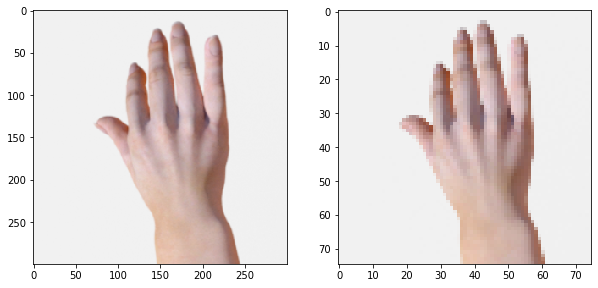

In [15]:
random = np.random.randint(0, len(y_train))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(y_train[random])
plt.subplot(122)
plt.imshow(X_train[random])

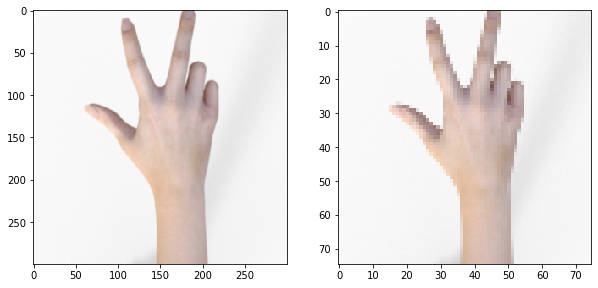

In [16]:
random = np.random.randint(0, len(y_train))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(y_train[random])
plt.subplot(122)
plt.imshow(X_train[random])

In [17]:
def simple_dae(inputs, kernel_size=3, filter_orig=16, layer_depth=4):
    filters = filter_orig
    x = inputs
    
    for i in range(layer_depth):
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2,
                   padding='same')(x)
        filters = min(filters * 2, 512)
    
    for i in range(layer_depth):
        filters = max(filters//2, filter_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu',
                           padding='same')(x)
    
    decoded = Conv2D(filters=inputs.shape[-1], kernel_size=1, activation='sigmoid',
                     padding='same')(x)
    
    return decoded

In [18]:
input_shape = X_train.shape
scale_factor = 4

In [19]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), 
    name=name)

In [20]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    name=name)

In [21]:
def concate_layers(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    resized_inputs = Upscale(name='upscale_input')(inputs)
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    decoded = ResizeToSame(name='dec_output_scale')([decoded, resized_inputs])
    return decoded

In [22]:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4

In [23]:
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, Input
from tensorflow.keras import Model

In [24]:
inputs = Input(shape=(None, None, input_shape[-1]))
decoded = concate_layers(inputs, kernel_size, filters_orig, layer_depth)

autoencoder = Model(inputs, decoded)

In [25]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
upscale_input (Lambda)          (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 1568        upscale_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 32832       conv2d[0][0]                     
______________________________________________________________________________________________

In [26]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True)
]

In [27]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mae')

In [28]:
autoencoder.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test),
                callbacks=callbacks)

Train on 2520 samples, validate on 372 samples
Epoch 1/200
2520/2520 [==============================] - 271s 108ms/sample - loss: 0.2648 - val_loss: 0.1513
Epoch 2/200
2520/2520 [==============================] - 269s 107ms/sample - loss: 0.1809 - val_loss: 0.1224
Epoch 3/200
2520/2520 [==============================] - 267s 106ms/sample - loss: 0.1638 - val_loss: 0.1166
Epoch 4/200
2520/2520 [==============================] - 282s 112ms/sample - loss: 0.1562 - val_loss: 0.1014
Epoch 5/200
2520/2520 [==============================] - 287s 114ms/sample - loss: 0.1113 - val_loss: 0.0818
Epoch 6/200
2520/2520 [==============================] - 287s 114ms/sample - loss: 0.0797 - val_loss: 0.0661
Epoch 7/200
2520/2520 [==============================] - 287s 114ms/sample - loss: 0.0714 - val_loss: 0.0659
Epoch 8/200
2520/2520 [==============================] - 287s 114ms/sample - loss: 0.0680 - val_loss: 0.0609
Epoch 9/200
2520/2520 [==============================] - 278s 110ms/sample - loss

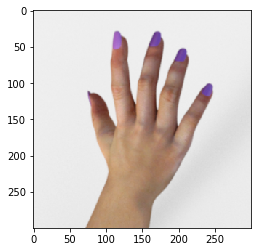

In [40]:
plt.imshow(y_train[100])

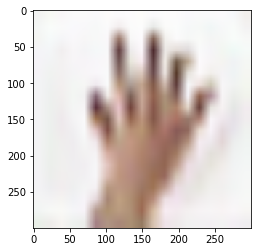

In [39]:
plt.imshow(autoencoder.predict(np.array(X_train[100]).reshape(1,75,75,3)).reshape(300,300,3))

In [41]:
autoencoder.save('dae_model.h5')

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
def prepare(features, scale_factor=4, augment=True,
                     return_batch_as_tuple=True, seed=None):

    image = features
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    original_size_mult = scaled_size * scale_factor
    
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3: # batched data:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        image = tf.image.random_flip_left_right(image)

        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2, 
                                                dtype=tf.float32, seed=seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32), 
                                            random_scale_factor), 
                                tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32), 
                                           random_scale_factor), 
                               tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    image_downscaled = tf.image.resize(image, scaled_size)
    
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}
    return features

In [3]:
hands_builder = tfds.builder('rock_paper_scissors')

In [4]:
hands_builder.download_and_prepare()

In [5]:
train, test = hands_builder.as_dataset(split=['train', 'test'], batch_size=-1, as_supervised=False)

In [6]:
train = train['image']

In [7]:
test = test['image']

In [8]:
downscaled_images, original_images = list(), list()
for i in range(len(train)):
    down, orig = prepare(train[i])
    downscaled_images.append(down)
    original_images.append(orig)

In [9]:
X_train = tf.convert_to_tensor(downscaled_images)
y_train = tf.convert_to_tensor(original_images)

In [10]:
downscaled_images, original_images = list(), list()
for i in range(len(test)):
    down, orig = prepare(test[i])
    downscaled_images.append(down)
    original_images.append(orig)

In [11]:
X_test = tf.convert_to_tensor(downscaled_images)
y_test = tf.convert_to_tensor(original_images)

In [12]:
X_train.shape, y_train.shape

(TensorShape([2520, 75, 75, 3]), TensorShape([2520, 300, 300, 3]))

In [13]:
X_test.shape

TensorShape([372, 75, 75, 3])

In [14]:
y_test.shape

TensorShape([372, 300, 300, 3])

In [15]:
from tensorflow.keras.layers import Lambda

In [16]:
scale_factor=4

In [17]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)

In [18]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, tf.shape(images)[-3:-1] * scale_factor), 
    name=name)

In [19]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dropout, Conv2DTranspose, MaxPooling2D, concatenate

In [20]:
def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Helper function to name all our layers.
    """
    def name_layer_fn(layer):
        return '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)
    
    return name_layer_fn


def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                  kernel_initializer='he_normal', padding='same',
                  name_fn=lambda layer: "conv_bn_lrelu-{}".format(layer)):
    """
    Return a function behaving like a sequence convolution + BN + lReLU.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param kernel_initializer:   Name of kernel initialization method
    :param padding:              Name of padding option
    :param name_fn:              Function to name each layer of this sequence
    :return:                     Function chaining layers
    """
    
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, 
                   activation=None, kernel_initializer=kernel_initializer, 
                   padding=padding, name=name_fn('conv'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        return x
    
    return block


def unet_conv_block(filters, kernel_size=3,
                    batch_norm=True, dropout=False, 
                    name_prefix="enc_", name_suffix=0):
    """
    Return a function behaving like a U-Net convolution block.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              NFlag to perform dropout between the two convs
    :param name_prefix:          Prefix for the layer names
    :param name_suffix:          FSuffix for the layer names
    :return:                     Function chaining layers
    """
    
    def block(x):
        # First convolution:
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)

        # Second convolution:
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)

        return x
    
    return block

In [21]:
# As the dimensions of our images are not normalized, and often not even, it is
# possible that after downsampling and upsampling, we do not reobtain the original size
# (with a difference of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the generated
# image to the dimensions of the target one:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[-3:-1]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)


def unet(x, layer_depth=4, filters_orig=32, kernel_size=4, 
         batch_norm=True, dropout=True, final_activation='sigmoid'):
    """
    Define a U-Net network.
    :param x:                    Input tensor/placeholder
    :param filters_orig:         Number of filters for the 1st CNN layer
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              Flag to perform dropout
    :param final_activation:     Name of activation function for the final layer
    :return:                     Network (Keras Functional API)
    """
    num_channels = x.shape[-1]
    
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        # Convolution block:
        x_conv = unet_conv_block(filters, kernel_size, 
                                 dropout=dropout, batch_norm=batch_norm, 
                                 name_prefix="enc_", name_suffix=i)(x)
        
        # We save the pointer to the output of this encoding block,
        # to pass it to its parallel decoding block afterwards:
        outputs_for_skip.append(x_conv)

        # Downsampling:
        x = MaxPooling2D(2)(x_conv)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(filters, kernel_size, dropout=dropout, 
                        batch_norm=batch_norm, name_suffix='_btleneck')(x)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        # Upsampling:
        name_fn = name_layer_factory(3, "ups_", i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, 
                            activation=None, kernel_initializer='he_normal', 
                            padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
    
        # Concatenation with the output of the corresponding encoding block:
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))

        # Convolution block:
        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, 
                            batch_norm=batch_norm, dropout=use_dropout,
                            name_prefix="dec_", name_suffix=i)(x)

    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out1')(x)  
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out2')(x)    
    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, 
               padding='same', name='dec_output')(x)
    
    return x

In [22]:
batch_size = 32
kernel_size = 4
filters_orig = 32
layer_depth = 4
use_batch_norm = batch_size > 1

In [23]:
inputs_fixed = tf.keras.Input(shape=(91, 91, 3), name = 'input')

In [24]:
X_train.shape

TensorShape([2520, 75, 75, 3])

In [25]:
y_train.shape

TensorShape([2520, 300, 300, 3])

In [26]:
input_shape = y_train.shape

In [27]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(None, None, input_shape[-1]), name='input')
resized_inputs = Upscale(name='upscale_inputs')(inputs)
outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)

In [28]:
unet_model = tf.keras.Model(inputs, outputs)

In [29]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
upscale_inputs (Lambda)         (None, None, None, 3 0           input[0][0]                      
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)            (None, None, None, 3 1568        upscale_inputs[0][0]             
__________________________________________________________________________________________________
enc_bn0-1 (BatchNormalization)  (None, None, None, 3 128         enc_conv0-1[0][0]                
______________________________________________________________________________________________

In [30]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

In [31]:
unet_model.compile(optimizer=optimizer, loss='mae')

In [ ]:
unet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=8, callbacks=[tf.keras.callbacks.EarlyStopping(), tf.keras.callbacks.TensorBoard(log_dir='./graph')])

Train on 2520 samples, validate on 372 samples
Epoch 1/10
1928/2520 [=====================>........] - ETA: 36:09 - loss: 0.1048 - accuracy: 0.2362